# Анализ результатов А/В-теста для интернет-магазина <a name="0"></a>

Исследование проведено для отдела маркетинга интернет-магазина с целью приоритезировать список гипотез о способах увеличения выручки компании, а также проанализировать результаты А/В-теста.

____
### Оглавление

#### [Часть 1. Изучение и приоритезация рабочих гипотез](#1)

   [1.1 Загрузка необходимых для анализа библиотек](#1.1)  
   [1.2 Изучение файла с гипотезами](#1.2)  
   [1.3 Приоритезация гипотез](#1.3)  
   [1.4 Выводы](#1.4)

#### [Часть 2. Первичное изучение полученных в ходе A/B-теста данных](#2)

   [2.1 Загрузка файлов с данными](#2.1)  
   [2.2 Выводы: описание полученных данных](#2.2)  
   [2.3 Изменение типов данных](#2.3)  

#### [Часть 3. Анализ A/B-теста](#3)

   [3.1 Оценка кумулятивных показателей выручки, среднего чека и конверсий](#3.1)  
   [3.2 Поиск и устранение аномалий в результатах теста](#3.2)  
   [3.3 Статистическое исследование результатов](#3.3)  
   [3.4 Итоги анализа результатов А/В-теста](#3.4)    

#### [Часть 4. Итоговые выводы исследования](#4)
____

 ## Часть 1. Изучение и приоритезация рабочих гипотез <a name='1'></a>

### 1.1 Загрузка необходимых для анализа библиотек <a name='1.1'></a>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Изучение файла с гипотезами <a name='1.2'></a>

In [2]:
hypothesis_data_file = "../datasets/AB-test_for_online_store.csv"
ab_test_data_orders = "../datasets/AB-test_for_online_store_orders.csv"
ab_test_data_visitors = "../datasets/AB-test_for_online_store_visitors.csv"

In [3]:
# загрузим файл с гипотезами
hypothesis = pd.read_csv(hypothesis_data_file)

# выведем общую информацию о датафрейме
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
# скорректируем названия столбцов
hypothesis = hypothesis.rename(columns={'Hypothesis':'hypothesis',
                           'Reach':'reach',
                           'Impact':'impact',
                           'Confidence':'confidence',
                           'Efforts':'efforts'})

# увеличим ширину колонок
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

# изучим первые строки таблицы и проверим результат
display(hypothesis.head(3))

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3


**Данные в таблице отображаются корректно**, нет пропусков и необходимости работать с типами данных. В таблице содержится информация об оценках гипотез по ряду критериев, необходимых для их приоритезации. В датафрейме описаны следующие колонки (для удобства и аккуратности кода наименования колонок были переведены в единый нижний регистр):  
* `hypothesis` — краткое описание гипотезы;  
* `reach` — охват пользователей;  
* `impact` — влияние на пользователей;  
* `confidence` — уверенность в гипотезе;  
* `efforts` — затраты ресурсов на проверку гипотезы (чем выше оценка, тем дороже реализация).  

Все параметры оценок считаются по 10-бальной шкале.
  
**На данный момент у нас 9 рабочих гипотез, которые необходимо приоритезировать.**

### 1.3 Приоритезация гипотез <a name='1.3'></a>

Для приоритезации гипотез используем фреймворки RICE и ICE, которые рассчитываются по формулам:  
  
$$ICE = \frac{Impact * Confidence}{Efforts}$$
  

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [5]:
# рассчитаем показатель ICE и округлим до 1 занка после запятой
hypothesis['ice_score'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 1)

# отсортируем по убыванию приоритета и выведем топ-3
hypothesis[['hypothesis', 'ice_score']].sort_values(by='ice_score', ascending=False).head(3)

,hypothesis,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2


In [6]:
# рассчитаем показатель RICE
hypothesis['rice_score'] = (hypothesis['reach'] 
                            * hypothesis['impact'] 
                            * hypothesis['confidence'] 
                            / hypothesis['efforts']
                           )

# отсортируем по убыванию приоритета и выведем топ-3
hypothesis[['hypothesis', 'rice_score']].sort_values(by='rice_score', ascending=False).head(3)

,hypothesis,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0


### 1.4 Выводы <a name='1.4'></a>

Для оценки приоритета гипотез применили метод ICE и его модификацию — RICE. Расчитать первый показатель можно по формуле `ICE = (Impact x Confidence) / Efforts`, а второй — `RICE score = (Reach x Impact x Confidence) / Efforts`. В топ-5 в обоих случаях вошли гипотезы 0, 2, 6, 7 и 8, но их порядок по убыванию приоритета различается. Это связано с тем, что метод RICE учитывает дополнительный параметр `reach` — охват пользователей, которых затронет изменение. Наилучший пример силы влияния одного этого параметра можно проследить на гипотезе 7, для которой ICE=16.2, а RICE=112, так как параметр охвата оценен в 10 (затронет всех пользователей).  
  
Так как метод RICE учитывает больше параметров при оценке приоритета гипотез, рекомендуем ориентироваться на него (метод ICE подтверждает, что оценки выставлены корректно и топ-5 гипотез совпадает по составу). 
  
**Выделим топ-3 по показателю RICE:**  
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа  
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  

## Часть 2. Первичное изучение полученных в ходе A/B-теста данных <a name='2'></a>

### 2.1 Загрузка файлов с данными <a name='2.1'></a>

In [7]:
# загрузим данные А/В-теста о сделанных заказах
orders_data = pd.read_csv(ab_test_data_orders)
orders_data.head(3)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [8]:
# переименуем названия колонок для удобства и приведем их в единый формат
orders_data = orders_data.rename(columns={'transactionId':'transaction_id',
                                          'visitorId':'visitor_id'})

# общая информация о данных в датафрейме orders_data
orders_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
# загрузим данные А/В-теста о посещениях сайта
visitors_data = pd.read_csv(ab_test_data_visitors)
visitors_data.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [10]:
# общая информация о данных в датафрейме visitors_data
visitors_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


### 2.2 Выводы: описание полученных данных <a name='2.2'></a>

Результаты проведенного А/В-теста хранятся в двух датафреймах.  
  
В таблице `orders_data` хранятся данные о сделанных заказах, 5 колонок:  
* `transaction_id` — уникальный ID заказа (тип данных `int64`)  
* `visitor_id` — уникальный ID клиента, сделавшего заказ (тип данных `int64`)  
* `date` — дата, когда сделан заказ (тип данных `object`)  
* `revenue` — выручка с заказа (тип данных `int64`)  
* `group` — идентификатор группы "А" или "В" (тип данных `object`)  

В таблице `orders_data` дубликатов не обнаружено, нет пропусков в данных, но необходимо скорректировать тип данных колонки `date` и перевести в формат `datetime`.  
  
В таблице `visitors_data` хранятся данные о посещениях сайта по дням, 3 колонки:  
* `date` — дата посещения (тип данных `object`)  
* `group` — идентификатор тестовой группы (тип данных `object`)  
* `visitors` — количество визитов в день для группы (тип данных `int64`)  

В таблице `visitors_data` дубликатов не обнаружено, нет пропусков в данных, но необходимо скорректировать тип данных колонки `date` и перевести в формат `datetime`.  
  
Перед началом анализа результатов теста, приведем данные к нужному виду в следующем пункте.

### 2.3 Изменение типов данных <a name='2.3'></a>

In [11]:
# заменим тип данных в колонках date на корректний
for data in (orders_data, visitors_data):
    data['date'] = data['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
    # проверка
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


None

## Часть 3. Анализ A/B-теста <a name='3'></a> 

### 3.1 Оценка кумулятивных показателей выручки, среднего чека и конверсий <a name='3.1'></a>

In [12]:
# создадим датафрейм с комулятивными данными результатов А/В-теста

# шаг 1: создаем массив уникальных пар значений дат и групп теста
dates_groups = orders_data[['date', 'group']].drop_duplicates()

In [13]:
# шаг 2: соберем агрегированные кумулятивные по дням данные о заказах
orders_aggregated = (dates_groups
                     .apply(lambda x: 
                            # условия формирования среза данных
                            orders_data[np.logical_and(orders_data['date'] <= x['date'], 
                                                       orders_data['group'] == x['group'])]
                            # агрегирующая функция для среза
                            .agg({'date':'max', 
                                  'group':'max', 
                                  'transaction_id':pd.Series.nunique, 
                                  'visitor_id':pd.Series.nunique, 
                                  'revenue':'sum'}),
                            # применяем метод apply к каждой строке
                            axis=1)
                     .sort_values(by=['date', 'group'])
)

# проверим результат выполнения шага 2
orders_aggregated.head(3)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401


In [14]:
# шаг 3: соберем агрегированные кумулятивные данные по дням о посещениях сайта
visitors_aggregated = (dates_groups
                       .apply(lambda x: 
                              # условия формирования среза данных
                              visitors_data[np.logical_and(visitors_data['date'] <= x['date'],
                                                           visitors_data['group'] == x['group'])]
                              # агрегирующая функция для среза
                              .agg({'date':'max', 
                                    'group':'max', 
                                    'visitors':'sum'}),
                              # применяем метод apply к каждой строке
                              axis=1)
                       .sort_values(by=['date', 'group'])
)

# проверим результат выполнения шага 3
visitors_aggregated.head(3)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338


In [15]:
# шаг 4: # объединим кумулятивные данные в одной таблице
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
# переименуем название столбцов
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
# проверим результат
cumulative_data.head(3)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338


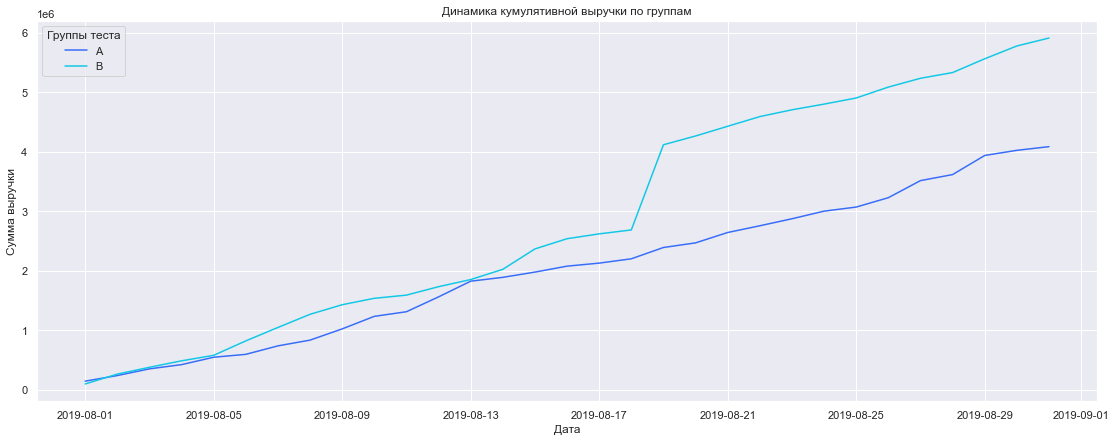

In [16]:
# датафрейм с кумулятивным кол-ом заказов и кмулятивной выручкой для группы А
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]
# датафрейм с кумулятивным кол-ом заказов и кмулятивной выручкой для группы B
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

# построим график кумулятивной выручки по группам
sns.set(rc={'figure.figsize':(19, 7)}, style='darkgrid', palette='rainbow')

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('Динамика кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма выручки')
plt.legend(title='Группы теста')
plt.show()

На графике видно, что выручка почти равномерно увеличивается в течение теста. В группе А рост происходит плавно и равномерно, а в группе В наблюдаем резкий скачок во второй половине августа. Это может говорить о наличии аномалий в количестве заказов или появлении нетипично дорогих заказов в выборке. На это необходимо обратить внимание при оценке результатов теста.

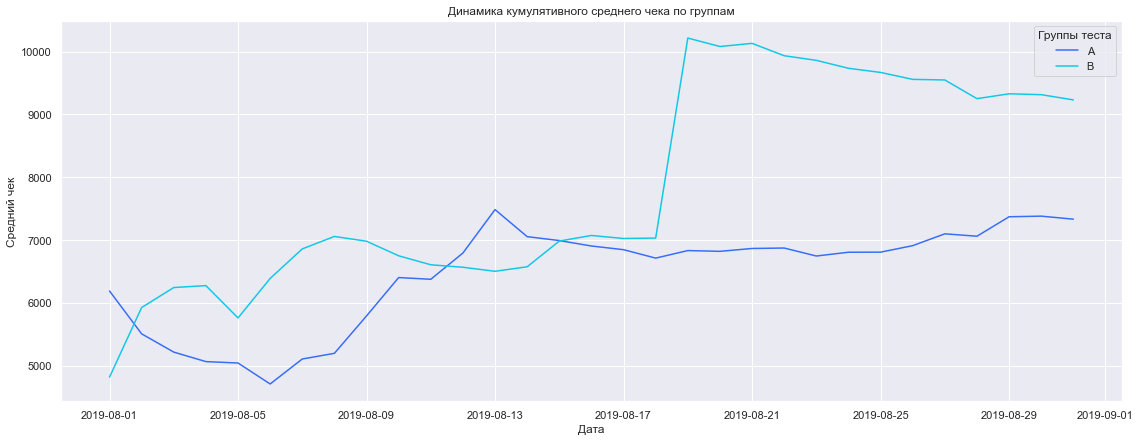

In [17]:
# построим график кумулятивного среднего чека по группам
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.title('Динамика кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend(title='Группы теста')
plt.show()

В начале средний сильно колебался для обоих групп, далее наблюдается рост в группе А и постепенный переход к равномерным колебаниям. Картину в группе В мешает оценить резкий всплеск 18-19 августа, после которого показатель начинает постепенно снижаться. Есть вероятность, что в обеих группах выбросы в виде аномально дорогих заказов влияют на результаты теста (для группы А такие заказы могли возникнуть с 11 по 13 августа). 

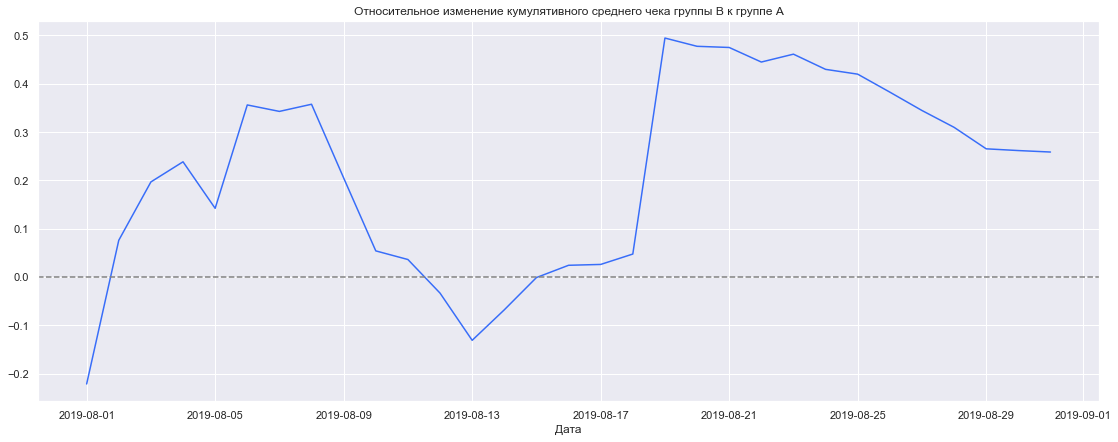

In [18]:
# построим график относительного изменения кумулятивного среднего чека группы B к группе A

# подготовим данные к анализу
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, 
                                                       left_on='date', 
                                                       right_on='date', 
                                                       how='left', 
                                                       suffixes=['_a', '_b'])

# построим график отношения средних чеков
plt.plot(merged_cumulative_revenue['date'], 
         (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])
         /(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1,
)

plt.title('Относительное изменение кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дата')
plt.axhline(y=0, color='grey', linestyle='--')
plt.show()

Резкие перепады значений в графике различия между сегментами подтверждают наличие дорогих заказов, которые влияют на результат теста и могут считаться выбросами. Эти заказы необходимо найти, изучить и, если это будет возможно, исключить из данных для проведения статистических тестов. 

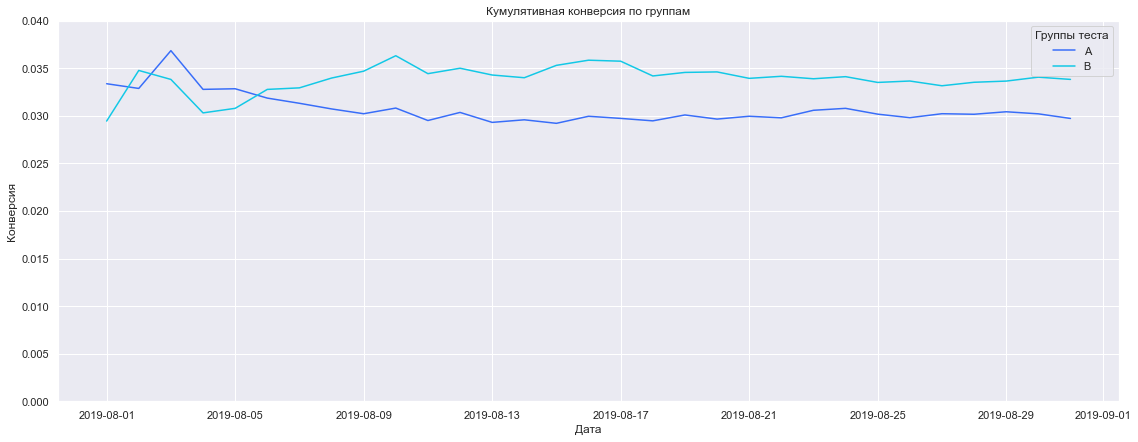

In [19]:
# подсчитаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
# выделим группу А
cumulative_conversion_a = cumulative_data[cumulative_data['group'] == 'A']
# выделим группу B
cumulative_conversion_b = cumulative_data[cumulative_data['group'] == 'B']

# построим график кумулятивной конверсии по группам
plt.plot(cumulative_conversion_a['date'], cumulative_conversion_a['conversion'], label='A')
plt.plot(cumulative_conversion_b['date'], cumulative_conversion_b['conversion'], label='B')

plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend(title='Группы теста')
plt.ylim(0, 0.04)
plt.show()

В начале теста конверсия группы В вырвалась вперед, а конверсия группы А, лидирующей первые дни теста, постепенно снижалась. Через 10-13 дней конверсии в обеих группах начали равномерно колебаться вокруг усредненного значения, при этом группа В сохранила прочное лидерство и на первый взгляд может показаться эффективнее — об этом судить пока рано. 

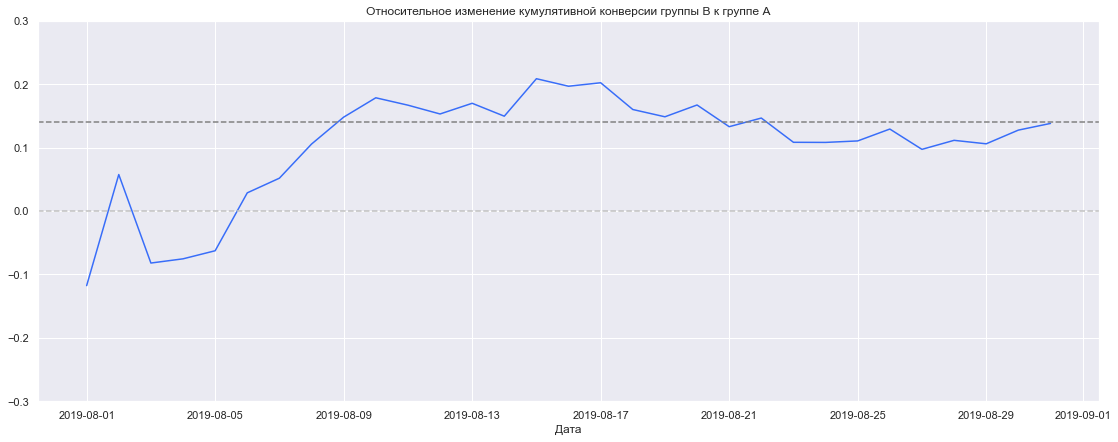

In [20]:
# построим график относительного изменения кумулятивной конверсии группы B к группе A
merged_cumulative_conversion = (cumulative_conversion_a
                                .merge(cumulative_conversion_b, 
                                       left_on='date', right_on='date',
                                       how='left',
                                       suffixes=['_a', '_b']))

plt.plot(merged_cumulative_conversion['date'],
         (merged_cumulative_conversion['conversion_b']/merged_cumulative_conversion['conversion_a']-1))

plt.title('Относительное изменение кумулятивной конверсии группы В к группе А')
plt.xlabel('Дата')
plt.axhline(y=0, color='silver', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')
plt.ylim(-0.3, 0.3)
plt.show()

В начале теста группа В то выигрывала, то проигрывала группе А. Через 5 дней теста конверсия группы В относительно группы А начала расти и быстро опередила группу А, больше не снижалась, продолжая колебаться. После 17 дней теста конверсии группы В начали снижаться и только в конце месяца стал вновь наблюдаться рост.  
  
На данном этапе видим, что колебания конверсии еще не установились и делать выводы по тесту пока нельзя, сначала необходимо проанализировать аномалии и изучить поведение сегментов без них.

### 3.2 Поиск и устранение аномалий в результатах теста <a name='3.2'></a>

In [21]:
# подготовим данные
orders_by_users = (orders_data
                   .drop(['group', 'revenue', 'date'], axis=1)
                   .groupby('visitor_id', as_index=False)
                   .agg({'transaction_id':pd.Series.nunique})
)

orders_by_users.columns = ['visitor_id', 'orders']

# изучим первые строки датафрейма
orders_by_users.sort_values(by='orders', ascending=False).head(3)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9


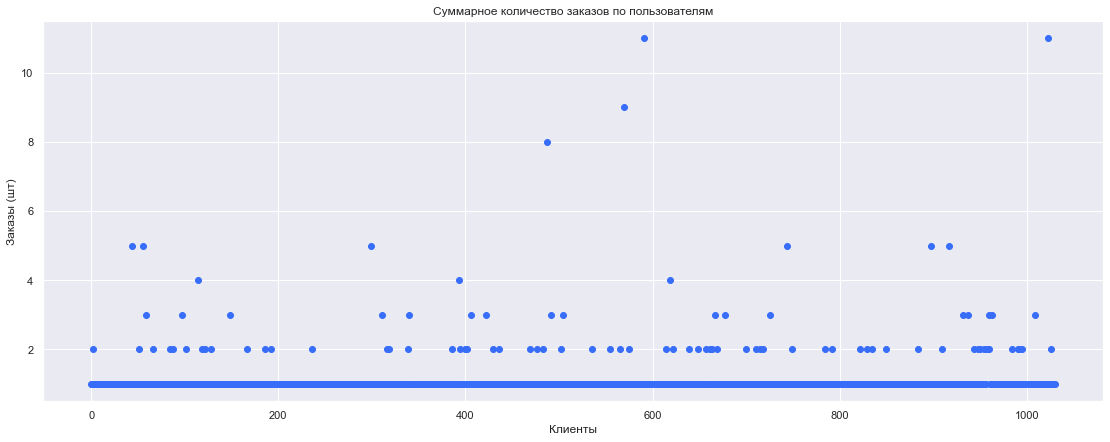

In [22]:
# построим точечный график количества заказов по пользователям
x_values_new = pd.Series(range(0, len(orders_by_users['visitor_id'])))
plt.scatter(x_values_new, orders_by_users['orders'])

plt.title('Суммарное количество заказов по пользователям')
plt.xlabel('Клиенты')
plt.ylabel('Заказы (шт)')
plt.show()

In [23]:
# обозначим границу для определения аномальных пользователей
np.percentile(orders_by_users['orders'], [95, 97, 99])

array([2., 2., 4.])

На графике видно, что большая часть заказов не превышает значения 2, однако, есть достаточное количество пользователей, которые делали от 2 до 4 заказов, чтобы определить границу аномалии, мы подсчитали персентили: не более 3% пользователей делают более 2 заказов и только 1% пользователей делает более 4 заказов.

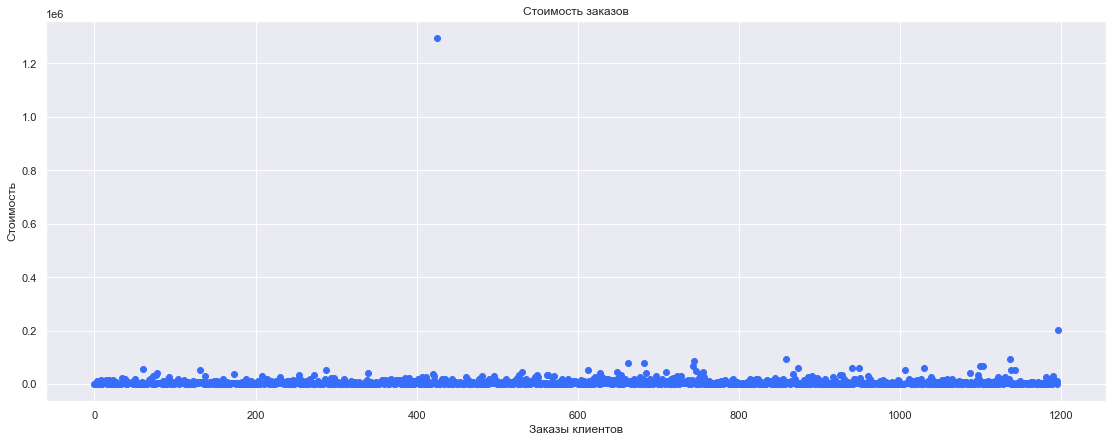

In [24]:
# построим точечный график стоимостей заказов
x_values = pd.Series(range(0, len(orders_data['revenue'])))
plt.scatter(x_values, orders_data['revenue'])

plt.title('Стоимость заказов')
plt.xlabel('Заказы клиентов')
plt.ylabel('Стоимость')
plt.show()

In [25]:
# обозначим границу для определения аномальных заказов
np.percentile(orders_data['revenue'], [95, 97, 99])

array([28000. , 35485. , 58233.2])

На графике видно, что аномально дорогих заказов не так много, но один из них сделан на сумму более 1,2 млн — это однозначно влияет на результаты теста. Далее мы выявили, что только 5% заказов дороже 28000 и только 1% превышает сумму 58233.  
  
**За аномальные значения возьмем заказы на сумму более 35000 (~3%) и пользователей, сделавших 5 и более заказов (1%)**

### 3.3 Статистическое исследование результатов <a name='3.3'></a>

**Анализ результатов А/В-теста по "сырым" данным**

In [26]:
# расчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

# вычислим кол-во визитов в день по группам
visitors_per_day_a = visitors_data[visitors_data['group'] == 'A'][['date', 'visitors']]
visitors_per_day_a.columns = ['date', 'visitors_a']

visitors_per_day_b = visitors_data[visitors_data['group'] == 'B'][['date', 'visitors']]
visitors_per_day_b.columns = ['date', 'visitors_b']

# переменные с данными о пользователях, сделавших хотя бы 1 заказ
users_orders_a = (orders_data[orders_data['group'] == 'A']
                  .groupby('visitor_id', as_index=False)
                  .agg({'transaction_id':'nunique'})
)
users_orders_a.columns = ['user_id', 'orders_cnt']

users_orders_b = (orders_data[orders_data['group'] == 'B']
                  .groupby('visitor_id', as_index=False)
                  .agg({'transaction_id':'nunique'})
)
users_orders_b.columns = ['user_id', 'orders_cnt']

In [27]:
# создадим переменные для проверки выборок критерием Манна_Уитни
sample_a_raw = pd.concat([users_orders_a['orders_cnt'], 
                      pd.Series(0, index=np.arange(visitors_per_day_a['visitors_a'].sum() 
                                                   - len(users_orders_a['orders_cnt'])), name='orders')], 
                     axis=0)

sample_b_raw = pd.concat([users_orders_b['orders_cnt'], 
                      pd.Series(0, index=np.arange(visitors_per_day_b['visitors_b'].sum() 
                                                   - len(users_orders_b['orders_cnt'])), name='orders')],
                      axis=0)

alpha = .05 # критический уровень статистической значимости

# применим критерий Манна_Уитни и рассчитаем относительную конверсию
results_convertion_raw = st.mannwhitneyu(sample_a_raw, sample_b_raw)

print('Значение p-value по критерию Манна-Уитни: {0:.3f}'.format(results_convertion_raw.pvalue))
if (results_convertion_raw.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

print()

print('Относительный прирост конверсии группы B: {0:.3f}'.format(sample_b_raw.mean()/sample_a_raw.mean()-1))

Значение p-value по критерию Манна-Уитни: 0.008
Отвергаем нулевую гипотезу: разница статистически значима

Относительный прирост конверсии группы B: 0.138


Так как в данных наблюдаются выбросы, применили u-критерий Манна-Уитни для проверки статистической значимости различий в конверсии групп А и В. По "сырым" данным получили значение p-value меньше 0.05, что означает, что **отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами А и В нет**. Относительный прирост конверсии группы В составил 13.8%. 

In [28]:
# расчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
results_avg_check_raw = st.mannwhitneyu(orders_data[orders_data['group'] == 'A']['revenue'], 
                                        orders_data[orders_data['group'] == 'B']['revenue'])

print('Значение p-value по критерию Манна-Уитни: {0:.3f}'.format(results_avg_check_raw.pvalue))
if (results_avg_check_raw.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

print()
 
print('Относительный прирост среднего чека группы B: {0:.3f}'
      .format(orders_data[orders_data['group'] == 'B']['revenue'].mean()
              /orders_data[orders_data['group'] == 'A']['revenue'].mean()
              -1))

Значение p-value по критерию Манна-Уитни: 0.365
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительный прирост среднего чека группы B: 0.259


Значение p-value значительно превышает критический уровень статистической значимости 0.05, что означает — **отвергнуть нулевую гипотезу не можем: причин считать, что в среднем чеке есть различия — нет.** При этом относительный прирост среднего чека группы В составил 25.9% — значительная разница, которая может быть вызвана выбросами в виде очень дорогих заказов.

In [29]:
# выделим аномальные значения:
# заказы на сумму более 35000 (~3%) и пользователей, сделавших 5 и более заказов (1%)
abnormal_orders = pd.concat([users_orders_a[users_orders_a['orders_cnt'] > 4]['user_id'],
                             users_orders_b[users_orders_b['orders_cnt'] > 4]['user_id']], axis=0)
abnormal_revenue = orders_data[orders_data['revenue'] > 35000]['visitor_id']
abnormal_revenue.name = 'user_id'

# список id "аномальных" пользователей 
abnormal_users = pd.concat([abnormal_orders, abnormal_revenue], axis=0).drop_duplicates().sort_values()
# узнаем кол-во таких пользователей
abnormal_users.count()

37

**Анализ результатов А/В-теста по "очищенным" данным**

In [30]:
# расчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным
sample_a_filtered = pd.concat([users_orders_a[np.logical_not(users_orders_a['user_id']
                                                             .isin(abnormal_users))]['orders_cnt'], 
                               pd.Series(0, index=np.arange(visitors_per_day_a['visitors_a'].sum() 
                                                            - len(users_orders_a['orders_cnt'])), name='orders')], 
                               axis=0)

sample_b_filtered = pd.concat([users_orders_b[np.logical_not(users_orders_b['user_id']
                                                             .isin(abnormal_users))]['orders_cnt'], 
                               pd.Series(0, index=np.arange(visitors_per_day_b['visitors_b'].sum() 
                                                            - len(users_orders_b['orders_cnt'])), name='orders')], 
                               axis=0)

result_convertion_filtered = st.mannwhitneyu(sample_a_filtered, sample_b_filtered)
print('Значение p-value по критерию Манна-Уитни: {0:.3f}'.format(result_convertion_filtered.pvalue))

if (result_convertion_filtered.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

print()
print('Относительный прирост конверсии группы B: {0:.3f}'
      .format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

Значение p-value по критерию Манна-Уитни: 0.007
Отвергаем нулевую гипотезу: разница статистически значима

Относительный прирост конверсии группы B: 0.157


По результатам теста, проведенного по очищенным данным, по-прежнему отвергаем нулевую гипотезу и можем считать, что разница между конверсиями групп А и В статистически значима. Однако теперь группа В лидирует относительно группы А на 15.7% — это говорит о том, что выбросы значительно влияли на относительные показатели конверсии и считать группу А более успешной по показателям конверсии было бы ошибочно.

In [31]:
# расчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
results_avg_check_filtered = st.mannwhitneyu(
    orders_data[np.logical_and(orders_data['group'] == 'A', 
                               np.logical_not(orders_data['visitor_id'].isin(abnormal_users)))]['revenue'], 
    orders_data[np.logical_and(orders_data['group'] == 'B', 
                               np.logical_not(orders_data['visitor_id'].isin(abnormal_users)))]['revenue'])

print('Значение p-value по критерию Манна-Уитни: {0:.3f}'.format(results_avg_check_filtered.pvalue))
if (results_avg_check_filtered.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")

print()

print('Относительный прирост среднего чека группы B: {0:.3f}'.format(
    orders_data[np.logical_and(orders_data['group'] == 'B', 
                               np.logical_not(orders_data['visitor_id'].isin(abnormal_users)))]['revenue'].mean()
    /orders_data[np.logical_and(orders_data['group'] == 'A', 
                                np.logical_not(orders_data['visitor_id'].isin(abnormal_users)))]['revenue'].mean()
    -1))

Значение p-value по критерию Манна-Уитни: 0.382
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Относительный прирост среднего чека группы B: 0.034


Изменений в проверке статистической значимости различия средних чеков по группам после очистки данных от выбросов нет, показатель относительного прироста отражает отсутствие различий.

### 3.4 Итоги анализа результатов А/В-теста <a name='3.4'></a>

В ходе исследования обнаружили:  
* есть статистически значимое различие по конверсии между группами А и В как по "сырым", так и по очищенным от выбросов данным,  
* по относительной конверсии группа В лидирует на 13.% по "сырым" данным и на 15.7% по очищенным,    
* по графику относительного изменения кумулятивной конверсии (группы В к группе А) лидирует группа В,  
* график относительного различия кумулятивного среднего чека показывает, что после нескольких резких колебаний группа В вышла вперед, однако, после постепенно значение начало снижаться и так и не вышло на плато, относительный прирост среднего чека группы В по очищенным данным составил -3.3%,  
* статистически значимого различия по среднему чеку между группами А и В как по "сырым" данным, так и после удаления аномалий нет.   

## Часть 4. Итоговые выводы исследования <a name='4'></a>

Анализ результатов А/В-теста показал наличие статистического различия по конверсии между группами, при этом относительный прирост конверсии группы В составил 15.7%. Статистической значимости различий между группами по среднему чеку нет.  
  
**Продолжать А/В-тест далее нецелесообразно**, так как кумулятивные показатели для групп А и В выровнялись и зафиксировались (график "Кумулятивная конверсия по группам") и маловероятно, что группа А покажет рост конверсии в дальнейшем. Группу В можно считать эффективнее группы А по показателю конверсии.  
  
При запуске новых тестов, рекомендуем обратить внимание на приоритеты гипотез, которые мы выявили с помощью фреймворков RICE и ICE. Гипотезы, которые вошли в топ-3 по приоритетности:  
* добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок,  
* добавить блоки рекомендаций товаров на сайт интернет-магазина, чтобы повысить конверсию и средний чек заказа,  
* добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей. 

____
**<center>[Перейти в начало исследования](#0)</center>**